In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler, Normalizer
import scipy.sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.base import BaseEstimator, TransformerMixin
import joblib
import warnings
warnings.filterwarnings("ignore")
import string
sns.set_style("dark")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from google.colab import files
uploaded = files.upload()

Saving twitter_training.csv to twitter_training.csv
Saving twitter_validation.csv to twitter_validation.csv


In [3]:
train_data = pd.read_csv('twitter_training.csv',encoding='latin-1')
test_data = pd.read_csv('twitter_validation.csv',encoding='latin-1')

data = {
    "train": [],
    "accuracy": [],
}

train_models = pd.DataFrame(data, columns=["train", "accuracy"])
data = {
    "test": [],
    "accuracy": [],
}

test_models = pd.DataFrame(data, columns=["test", "accuracy"])

In [4]:
print("Train Data\n ", train_data.head(5))
print("---------------------------------------------------------------------------------")

print("Test Data\n", test_data.head(5))

Train Data
    sentiment                                               text Unnamed: 2  \
0  Positive  im getting on borderlands and i will murder yo...        NaN   
1  Positive  I am coming to the borders and I will kill you...        NaN   
2  Positive  im getting on borderlands and i will kill you ...        NaN   
3  Positive  im coming on borderlands and i will murder you...        NaN   
4  Positive  im getting on borderlands 2 and i will murder ...        NaN   

  Unnamed: 3  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        NaN  
---------------------------------------------------------------------------------
Test Data
    number   platform   sentiment  \
0    3364   Facebook  Irrelevant   
1     352     Amazon     Neutral   
2    8312  Microsoft    Negative   
3    4371      CS-GO    Negative   
4    4433     Google     Neutral   

                                                text  
0  I mentioned on Facebook that I was struggling ...  
1  BBC News - 

In [5]:
class text_processing(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        lower=False,
        upper=False,
        remove_special_characters=False,
        remove_punctuation=False,
        remove_stop_words=False,
        stem_the_words=False,
    ) -> None:
        self.lower = lower
        self.upper = upper
        self.remove_special_characters = remove_special_characters
        self.remove_punctuation = remove_punctuation
        self.remove_stop_words = remove_stop_words
        self.stem_the_words = stem_the_words
        super().__init__()

    def fit(self, X, y=None):
        return self

    # for converting the text to lower case
    def __convert_text_lower(self, text):
        text = text.lower()
        return text

    def __lower_text(self, X):
        X = X.apply(self.__convert_text_lower)
        return X

    # for converting the text to upper case
    def __convert_text_upper(self, text):
        text = text.upper()
        return text

    def __upper_text(self, X):
        X = X.apply(self.__convert_text_upper)
        return X

    # for converting the text to words
    def __TextToWord(self, X):
        words = word_tokenize(X)
        return words

    # for removing Special Characters
    def __remove_spec(self, X):
        words = self.__TextToWord(X)
        fixed_words = []
        for w in words:
            if w.isalnum():
                fixed_words.append(w)
        return " ".join(fixed_words)

    def __Remove_Special_Characters(self, X):
        X = X.apply(self.__remove_spec)
        return X

    # for removing Punctuation
    def __remove_puncs(self, X):
        words = self.__TextToWord(X)
        punctuation = set(string.punctuation)
        fixed_words = []
        for w in words:
            if not punctuation.__contains__(w):
                fixed_words.append(w)
        return " ".join(fixed_words)

    def __Remove_Punctuation(self, X):
        X = X.apply(self.__remove_puncs)
        return X

    # for removing Stop Words
    def __remove_stop(self, X):
        stop_words = set(stopwords.words("english"))
        words = self.__TextToWord(X)
        fixed_words = []
        for w in words:
            if not stop_words.__contains__(w):
                fixed_words.append(w)
        return " ".join(fixed_words)

    def __Remove_stop_words(self, X):
        X = X.apply(self.__remove_stop)
        return X

    # for Stemming the words
    def __stem_text(self, text):
        stemmer = PorterStemmer()
        words = self.__TextToWord(text)
        stemmed_words = []
        for w in words:
            stemmed_words.append(stemmer.stem(w))
        return " ".join(stemmed_words)

    def __Stemming(self, X):
        X = X.apply(self.__stem_text)
        return X

    # we will apply the text processing based on the parameters
    def process_text(self, X):
        data = X.copy()
        # will lowercase the text
        if self.lower:
            data = self.__lower_text(data)
        # will uppercase the text
        if self.upper:
            data = self.__upper_text(data)
        # will remove the special characters
        if self.remove_special_characters:
            data = self.__Remove_Special_Characters(data)
        # will remove the punctuation
        if self.remove_punctuation:
            data = self.__Remove_Punctuation(data)
        # will remove the stop words
        if self.remove_stop_words:
            data = self.__Remove_stop_words(data)
        # will stem the words
        if self.stem_the_words:
            data = self.__Stemming(data)
        return data

    def transform(self, X, y=None):
        if isinstance(X, (scipy.sparse.csr_matrix, scipy.sparse.csc_matrix)):
            # Convert sparse matrix to dense array for text processing
            X = pd.Series(X.toarray().ravel())  # Convert to Series for apply
            X = X.astype(str)  # convert all to strings to apply .lower()
            X = self.process_text(X)
            # Convert back to sparse matrix if needed
            # CHANGE: Convert X to a numerical representation before creating csr_matrix
            X = vectorizer.transform(X) # Use vectorizer to get numerical representation
        else:
            X = X.astype(str)  # convert all to strings to apply .lower()
            X = self.process_text(X)
        return X

In [6]:
# removing Duplicate data
combine = [train_data, test_data]
for data_set in combine:
    print(data_set.duplicated().sum()) #identifying duplicates
print( "---------------------------------------------------------------------------------")
for data_set in combine:
    data_set.drop_duplicates(inplace=True)#dropping duplicates
    print(data_set.duplicated().sum())

4908
0
---------------------------------------------------------------------------------
0
0


In [7]:
train_x_train, test_x_test, train_y_train, test_y_test = train_test_split(
    train_data['text'], train_data['sentiment'], test_size=0.2, random_state=42
)

In [8]:
label_encoder = LabelEncoder()
train_y_train = label_encoder.fit_transform(train_y_train)
test_y_test = label_encoder.transform(test_y_test)

In [9]:
label_encoder.classes_

array(['Irrelevant', 'Negative', 'Neutral', 'Positive', nan], dtype=object)

In [10]:
def acc_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)


def conf_mat(model,train_x_train_processed, test_x_test_processed):
    pipeline_train_pred = model.predict(train_x_train_processed)
    pipeline_test_pred = model.predict(test_x_test_processed)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    cm = confusion_matrix(list(train_y_train), list(pipeline_train_pred))
    sns.heatmap(
        cm,
        annot=True,
        ax=ax[0],
        fmt="d",
        cmap="Greens",
    )
    ax[0].set_title("Train Data")
    ax[0].set_xlabel("Predicted Labels")
    ax[0].set_ylabel("True Labels")

    cm = confusion_matrix(list(test_y_test), list(pipeline_test_pred))
    sns.heatmap(
        cm,
        annot=True,
        ax=ax[1],
        fmt="d",
        cmap="Greens",
    )
    ax[1].set_title("Test Data")
    ax[1].set_xlabel("Predicted Labels")
    ax[1].set_ylabel("True Labels")

    plt.legend()
    plt.show()

In [11]:
# NB
"""
        Steps of model
        1. Text Processing
        2. Vectorization by using CountVectorizer for converting the text to numbers
        3. scaling the data by using StandardScaler
        3. Training the model by using Pipeline
"""

text_processing_odj = text_processing(
    lower=True,
    remove_special_characters=True,
    remove_punctuation=True,
    remove_stop_words=True,
    stem_the_words=False,
)
vectorizer = TfidfVectorizer()
classifier = MultinomialNB()
nb_pipeline = Pipeline(
    [
        ("text_processing", text_processing_odj),
        ("vectorizer", vectorizer),
        ("classifier", classifier),
    ]
)
nb_pipeline.fit(train_x_train, train_y_train)
joblib.dump(nb_pipeline, 'nb_model.pkl')  # Save the model
joblib.dump(vectorizer, 'vectorizer.pkl')

['vectorizer.pkl']

Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
Final Training Accuracy: 0.7837
Final Validation Accuracy: 0.7256


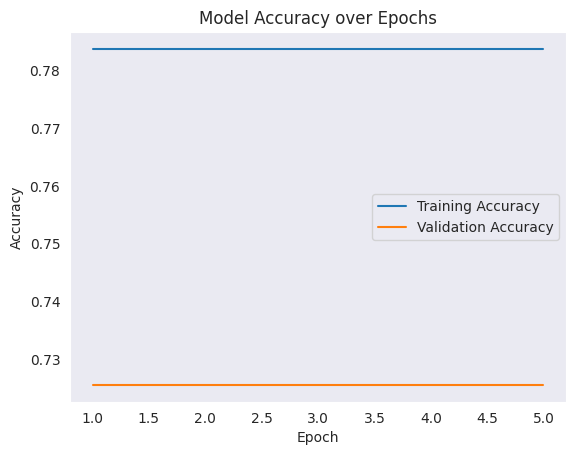

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Number of epochs to train
epochs = 5

# Store training and validation accuracy over epochs
train_accuracy = []
validation_accuracy = []

# Extract features (train_x_train) and target (train_y_train) from train_data
train_x_train = train_data['text']  # Assuming 'text' column contains your features
train_y_train = train_data['sentiment']  # Assuming 'sentiment' column contains your target

# Split data into train and validation (optional)
train_x_train, val_x, train_y_train, val_y = train_test_split(
    train_x_train, train_y_train, test_size=0.2, random_state=42
)

# Assuming label_encoder is already defined and fitted
train_y_train = label_encoder.transform(train_y_train)  # Transform training labels
val_y = label_encoder.transform(val_y)  # Transform validation labels

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    # Train the model for this epoch
    nb_pipeline.fit(train_x_train, train_y_train)

    # Predict on training and validation sets
    train_pred = nb_pipeline.predict(train_x_train)
    val_pred = nb_pipeline.predict(val_x)

    # Calculate and store accuracy
    train_acc = accuracy_score(train_y_train, train_pred)
    val_acc = accuracy_score(val_y, val_pred)
    train_accuracy.append(train_acc)
    validation_accuracy.append(val_acc)

# Print the final accuracy after all epochs
print(f"Final Training Accuracy: {train_accuracy[-1]:.4f}")
print(f"Final Validation Accuracy: {validation_accuracy[-1]:.4f}")

# Plot accuracy over epochs
plt.plot(range(1, epochs + 1), train_accuracy, label="Training Accuracy")
plt.plot(range(1, epochs + 1), validation_accuracy, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy over Epochs")
plt.show()

In [15]:
print(label_encoder.classes_)  # Display the mapping between labels and numerical values

['Irrelevant' 'Negative' 'Neutral' 'Positive' nan]


In [35]:
def predict_sentiments(user_input, vectorizer, model):
    """
    Predicts the sentiment for a given user input using the trained Naive Bayes model.

    Args:
    - user_input (str): The sentence entered by the user.
    - vectorizer (CountVectorizer): The fitted vectorizer used for text transformation.
    - model (MultinomialNB or any trained classifier): The trained sentiment analysis model.

    Returns:
    - str: Sentiment prediction result ("Positive", "Neutral", or "Negative").
    """
    if not user_input.strip():
        return "Please enter a valid sentence."

    # Preprocess the text using the text_processing step of the pipeline
    processed_text = model.named_steps['text_processing'].transform(pd.Series([user_input]))

    # CHANGE: Convert processed_text to a dense array before passing to vectorizer
    if isinstance(processed_text, (scipy.sparse.csr_matrix, scipy.sparse.csc_matrix)):
        processed_text = processed_text.toarray()

    # Vectorize the preprocessed text using the loaded vectorizer
    input_vectorized = vectorizer.transform(processed_text)

    # Make prediction
    prediction = model.named_steps['classifier'].predict(input_vectorized)[0]

    # Get the sentiment labels from the label encoder
    sentiment_labels = label_encoder.classes_

    # Map the prediction to the correct sentiment label
    sentiment = sentiment_labels[prediction]

    # Explicitly handle three sentiment labels
    if sentiment == sentiment_labels[0]:  # Assuming Negative is at index 0
        # Check for boundary cases and potentially classify as neutral
        if model.predict_proba(input_vectorized)[0][0] < 0.6: # Adjust the threshold as needed
            sentiment = "Neutral 😐"  # Classify as neutral if probability is below threshold
        else:
            sentiment = "Negative 😞"
    elif sentiment == sentiment_labels[1]:  # Assuming Neutral is at index 1
        sentiment = "Neutral 😐"
    elif sentiment == sentiment_labels[3]:  # Assuming Positive is at index 2
        sentiment = "Positive 😊"
    else:
        sentiment = "Unknown"  # Handle cases where prediction is outside the expected range

    # Return human-readable sentiment result
    return f"Sentiment: {sentiment}"

In [45]:
user_input = input("Enter a sentence to analyze sentiment: ")
result = predict_sentiments(user_input, vectorizer, nb_pipeline)
print(result)

Enter a sentence to analyze sentiment: I hate all things
Sentiment: Neutral 😐
